In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader
import torchvision.models as models
from scipy import linalg
import os

# Create directories for results and models
os.makedirs('Results', exist_ok=True)
os.makedirs('Models', exist_ok=True)

In [2]:
# Set random seed for reproducibility
torch.manual_seed(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda


In [3]:
# Hyperparameters
LEARNING_RATE = 5e-5
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3  
NOISE_DIM = 100
NUM_EPOCHS = 40
FEATURES_DISC = 64 
FEATURES_GEN = 64 
NUM_CLASSES = 10
EMBED_SIZE = 100

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = datasets.CIFAR10(root="./dataset/CIFAR10data", download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified


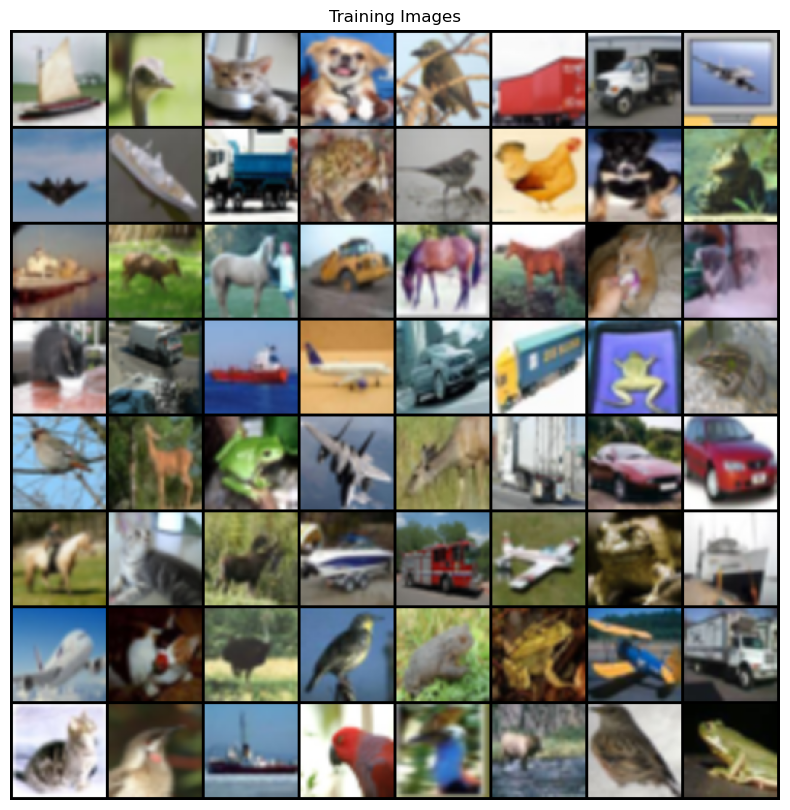

In [4]:
# Display a batch of real images
real_batch = next(iter(data_loader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:BATCH_SIZE], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [5]:
# Generator model
class Generator(nn.Module):
    def __init__(self, num_classes, img_size, embed_size, noise_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.network = nn.Sequential(
            nn.ConvTranspose2d(noise_dim + embed_size, features_g * 16, 4, 1, 0, bias=False),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
        self.embedding = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.9),
            nn.ReLU(),
        )

    def forward(self, noise, labels):
        embedded = self.embedding(labels).unsqueeze(2).unsqueeze(3)
        input_data = torch.cat([noise, embedded], dim=1)
        return self.network(input_data)

In [6]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_size, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
        )
        self.validity_layer = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.label_layer = nn.Sequential(
            nn.Conv2d(512, num_classes, 4, 1, 0, bias=False),
            nn.LogSoftmax(dim=1)
        )

    def _block(self, in_channels , out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        x = self.model(x)
        validity = self.validity_layer(x).view(-1)
        labels = self.label_layer(x).view(-1, NUM_CLASSES)
        return validity, labels

In [7]:
# Weight initialization
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [8]:
# Instantiate models
generator = Generator(NUM_CLASSES, IMAGE_SIZE, EMBED_SIZE, NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
discriminator = Discriminator(NUM_CLASSES, IMAGE_SIZE, CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(generator)
initialize_weights(discriminator)

In [9]:
# Set models to training mode
generator.train()
discriminator.train()

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
  )
  (validity_layer): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
  (label_layer): Sequential(
    (0): Conv2d(512, 10, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LogSoftmax(dim=1)
  )
)

In [10]:
# InceptionV3 model for FID calculation
class InceptionV3(nn.Module):
    DEFAULT_BLOCK_INDEX = 3
    BLOCK_INDEX_BY_DIM = {64: 0, 192: 1, 768: 2, 2048: 3}

    def __init__(self, output_blocks=[DEFAULT_BLOCK_INDEX], resize_input=True, normalize_input=True, requires_grad=False):
        super(InceptionV3, self).__init__()
        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, 'Last possible output block index is 3'

        inception = models.inception_v3(pretrained=True)
        self.blocks = nn.ModuleList()

        # Define blocks
        block0 = [inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3, inception.Conv2d_2b_3x3, nn.MaxPool2d(kernel_size=3, stride=2)]
        self.blocks.append(nn.Sequential(*block0))

        if self.last_needed_block >= 1:
            block1 = [inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3, nn.MaxPool2d(kernel_size=3, stride=2)]
            self.blocks.append(nn.Sequential(*block1))

        if self.last_needed_block >= 2:
            block2 = [inception.Mixed_5b, inception.Mixed_5c, inception.Mixed_5d, inception.Mixed_6a, inception.Mixed_6b, inception.Mixed_6c, inception.Mixed_6d, inception.Mixed_6e]
            self.blocks.append(nn.Sequential(*block2))

        if self.last_needed_block >= 3:
            block3 = [inception.Mixed_7a, inception.Mixed_7b, inception.Mixed_7c, nn.AdaptiveAvgPool2d(output_size=(1, 1))]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

In [11]:
# FID calculation functions
def calculate_activation_statistics(images, model, batch_size=128, dims=2048, cuda=False):
    model.eval()
    act = np.empty((len(images), dims))

    if cuda:
        batch = images.cuda()
    else:
        batch = images
    pred = model(batch)[0]

    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [12]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, 'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, 'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('FID calculation produces singular product; adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)

In [13]:
def calculate_frechet(images_real, images_fake, model):
    mu_1, std_1 = calculate_activation_statistics(images_real, model, cuda=True)
    mu_2, std_2 = calculate_activation_statistics(images_fake, model, cuda=True)
    fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_value

In [14]:
# Training setup
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
dis_optimizer = optim.Adam(discriminator.parameters(), LEARNING_RATE, betas=(0.5, 0.999))
gen_optimizer = optim.Adam(generator.parameters(), LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [15]:
# Lists to store losses and FID scores
gen_loss_list = []
disc_loss_list = []
fid_scores = []

In [16]:
print("Training Started!")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    for batch_idx, (real_images, labels) in enumerate(data_loader):
        real_images = real_images.to(device)
        labels = labels.to(device)
        mini_batch_size = real_images.size(0)

        # Train Discriminator
        discriminator.zero_grad()
        real_labels = torch.full((mini_batch_size,), 1.0, dtype=torch.float).to(device)
        disc_real, disc_real_labels = discriminator(real_images)
        loss_disc_real = criterion(disc_real, real_labels)

        # Generate fake images
        fake_labels = torch.full((mini_batch_size,), 0.0, dtype=torch.float).to(device)  # Ensure this is float
        noise = torch.randn(mini_batch_size, NOISE_DIM, 1, 1).to(device)
        sample_labels = torch.randint(0, 10, (mini_batch_size,), dtype=torch.long).to(device)
        fake_images = generator(noise, sample_labels)
        disc_fake, disc_fake_labels = discriminator(fake_images.detach())

        # Compute loss for fake images
        loss_disc_fake = criterion(disc_fake, fake_labels)

        # Average discriminator loss
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        loss_disc.backward()
        dis_optimizer.step()

        # Train Generator
        generator.zero_grad()
        real_labels.fill_(1.0)
        gen_output, _ = discriminator(fake_images)
        loss_gen = criterion(gen_output, real_labels)
        loss_gen.backward()
        gen_optimizer.step()

        # Store losses
        gen_loss_list.append(loss_gen.item())
        disc_loss_list.append(loss_disc.item())

        # Calculate FID score
        if (epoch % 5 == 0) and (batch_idx == len(data_loader) - 1):
            fid_score = calculate_frechet(real_images, fake_images, model)
            fid_scores.append(fid_score)
            print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(data_loader)} \
                  Loss Discriminator: {loss_disc:.3f}, Loss Generator: {loss_gen:.3f}, FID Score: {fid_score:.3f}")

# Save results
end_time = time.time()
print(f'Training completed in {end_time - start_time:.2f} seconds.')

Training Started!


NameError: name 'model' is not defined

In [17]:
# Save loss data
os.makedirs('Results/Loss_Data', exist_ok=True)
np.save('Results/Loss_Data/Generator_Loss', gen_loss_list)
np.save('Results/Loss_Data/Discriminator_Loss', disc_loss_list)

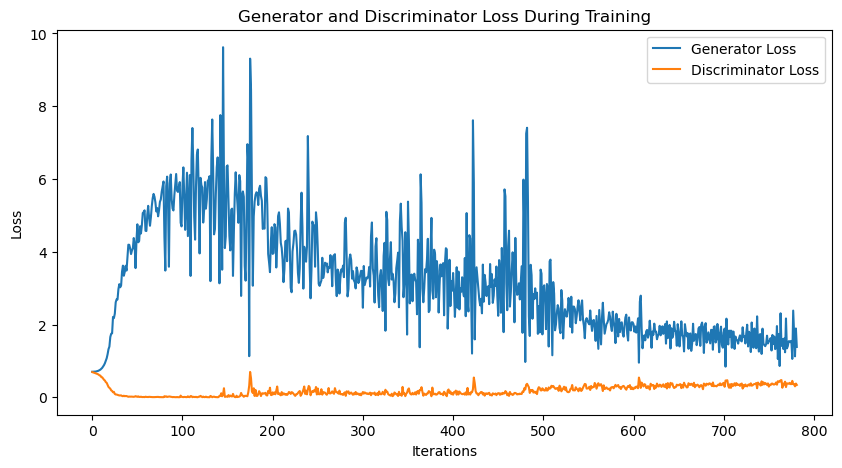

In [18]:
# Plotting losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_loss_list, label="Generator Loss")
plt.plot(disc_loss_list, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('Results/Loss_Data/Loss_Chart.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()

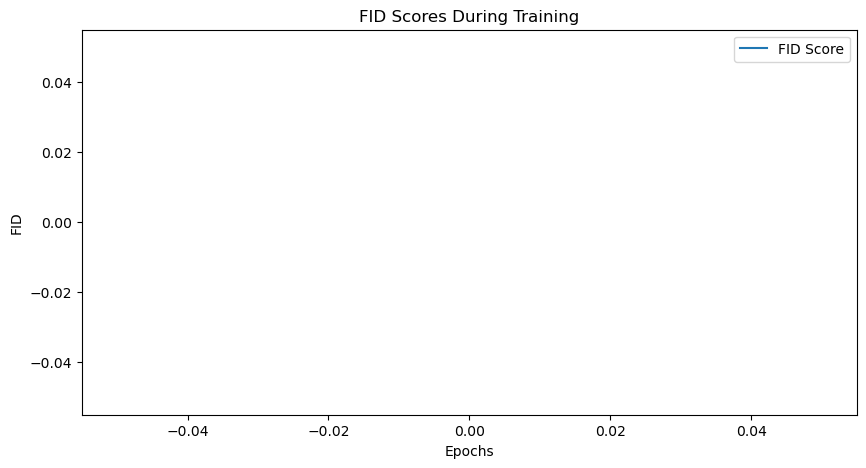

In [19]:
# Plotting FID scores
plt.figure(figsize=(10, 5))
plt.title("FID Scores During Training")
plt.plot(fid_scores, label="FID Score")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig('Results/FID_Scores/FID_Chart.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [20]:
# Save FID scores
os.makedirs('Results/FID_Scores', exist_ok=True)
np.save('Results/FID_Scores/FID_Scores', fid_scores)

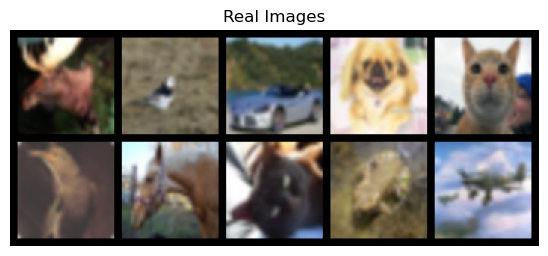

In [21]:
# Display real and fake images
real_batch = next(iter(data_loader))
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:10], nrow=5, padding=5, normalize=True).cpu(), (1, 2, 0)))

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 32 but got size 16 for tensor number 1 in the list.

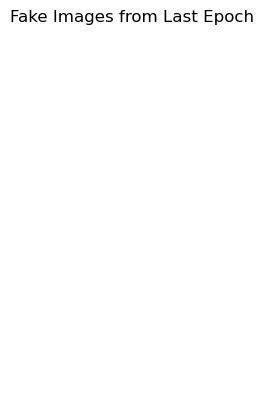

In [22]:
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images from Last Epoch")
with torch.no_grad():
    fake_images = generator(fixed_noise, sample_labels).detach().cpu()
plt.imshow(np.transpose(utils.make_grid(fake_images, nrow=5, padding=5, normalize=True), (1, 2, 0)))
plt.savefig('Results/Generated_Images/Fake_Images.pdf', format='pdf', dpi=100, bbox_inches='tight')
plt.show()

In [23]:
if not os.path.exists('Results/FID_score'):
    os.makedirs('Results/FID_score')

# Save the FID list
np.save('Results/FID_score/ACGAN_FID', FID_list)

# Compute and print stats if FID_list has elements
if len(FID_list) > 0:
    min_fid = np.min(FID_list)
    max_fid = np.max(FID_list)
    mean_fid = np.mean(FID_list)
    last_five_fid = FID_list[-5:] if len(FID_list) >= 5 else FID_list
    print("Min FID:", min_fid)
    print("Max FID:", max_fid)
    print("Mean FID:", mean_fid)
    print("Last 5 FID scores:", last_five_fid)
else:
    print("FID_list is empty. No stats to compute.")

NameError: name 'FID_list' is not defined